<a href="https://colab.research.google.com/github/sanzidarahman1/ENGG_680_Project/blob/main/LSTM_EB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - loss: 0.0028 - mae: 0.0288 - val_loss: 6.3104e-04 - val_mae: 0.0081
Epoch 2/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 9.7078e-04 - mae: 0.0129 - val_loss: 4.5740e-04 - val_mae: 0.0084
Epoch 3/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - loss: 6.7950e-04 - mae: 0.0109 - val_loss: 4.6937e-04 - val_mae: 0.0126
Epoch 4/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 6.8156e-04 - mae: 0.0106 - val_loss: 3.6180e-04 - val_mae: 0.0061
Epoch 5/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - loss: 5.3755e-04 - mae: 0.0092 - val_loss: 2.9231e-04 - val_mae: 0.0050
Epoch 6/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - loss: 3.7714e-04 - mae: 0.0081 - val_loss: 3.0470e-04 - val_mae: 0.0073
Epoch 7/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 4.7895e-04 - mae: 0.0086 - val_loss: 2.6070e-04 - val_mae: 0.0051
Epoch 8/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 3.5026e-04 - mae: 0.0078 - val_loss: 3.2286e-0

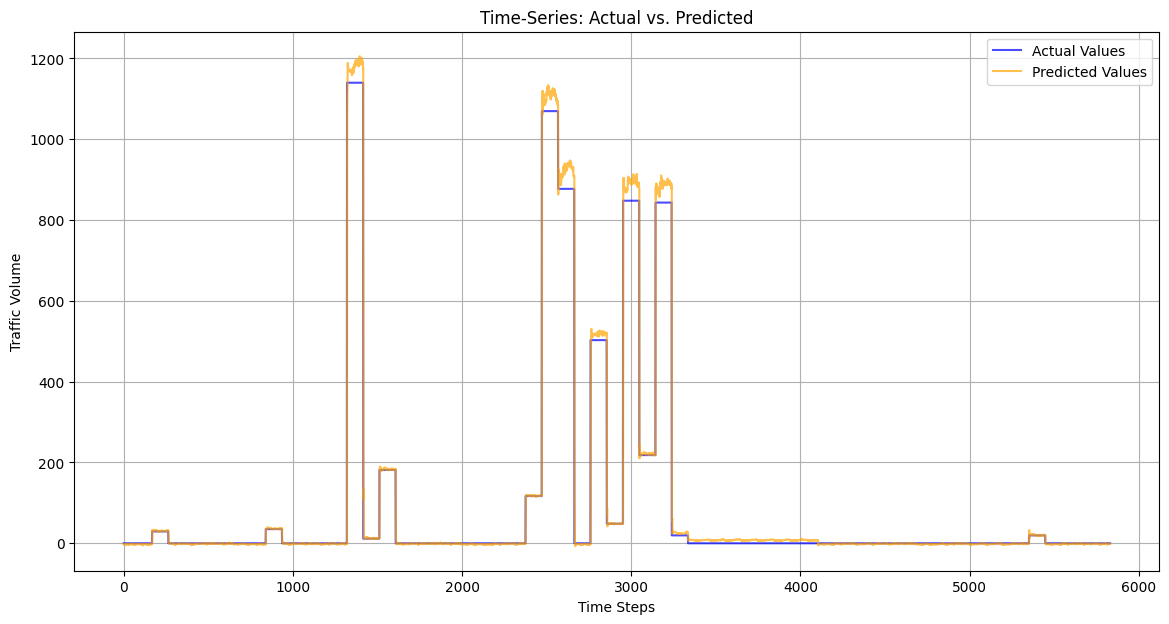

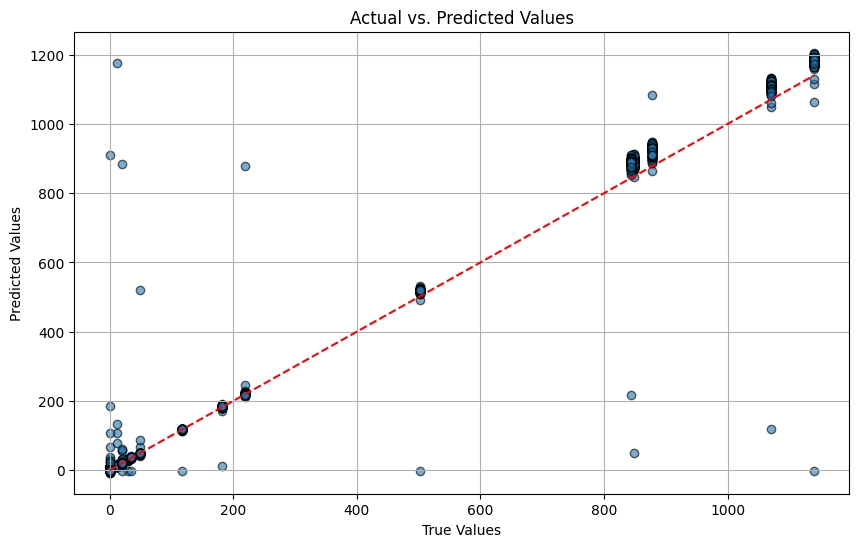

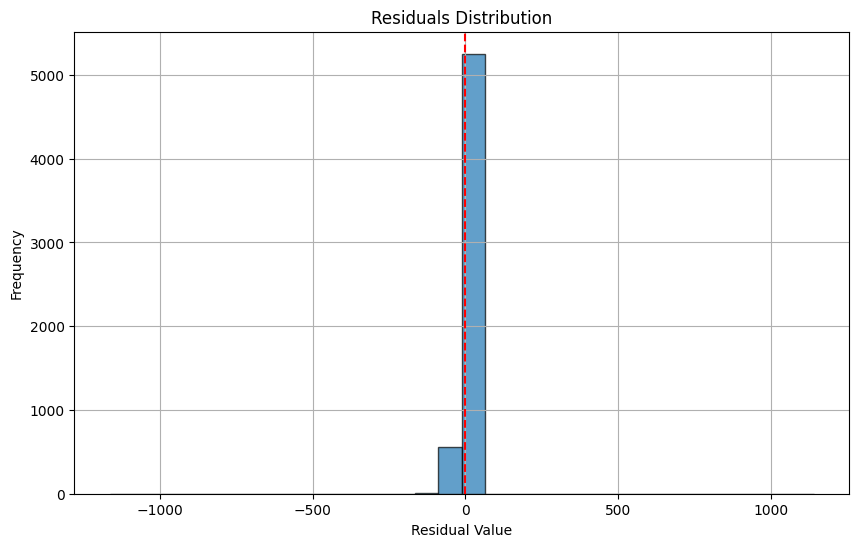

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

# Load the data
train_val_file_path = 'train and validation_EB(1).xlsx'
test_file_path = 'test_EB.xlsx'

train_val_data = pd.read_excel(train_val_file_path)
test_data = pd.read_excel(test_file_path)

# Combine datasets for preprocessing consistency
data = pd.concat([train_val_data, test_data]).sort_values(by=['date', 'time']).reset_index(drop=True)

# Convert date and time columns
data['date'] = pd.to_datetime(data['date'])
data['time'] = pd.to_datetime(data['time'], format='%H:%M:%S').dt.time

# Encode categorical variables
data['weekend/holiday (y/n)'] = data['weekend/holiday (y/n)'].map({'y': 1, 'n': 0})
data['stampede (y/n)'] = data['stampede (y/n)'].map({'y': 1, 'n': 0})
data = pd.get_dummies(data, columns=['Day_Type'], prefix='DayType')

# Add lagged weather features
data['temp_lag'] = data['temp. (C)'].shift(1).fillna(0)
data['precip_lag'] = data['daily precip. (mm)'].shift(1).fillna(0)
data['wind_lag'] = data['wind (km/h)'].shift(1).fillna(0)

# Normalize numeric features
scaler = MinMaxScaler()
features = ['vehicle count', 'temp. (C)', 'daily precip. (mm)', 'wind (km/h)',
            'temp_lag', 'precip_lag', 'wind_lag', 'weekend/holiday (y/n)', 'stampede (y/n)'] + \
           [col for col in data.columns if 'DayType_' in col]
data[features] = scaler.fit_transform(data[features])

# Separate training/validation and test datasets
train_val_data = data.iloc[:-len(test_data)]  # First 10 months
test_data = data.iloc[-len(test_data):]       # Last 2 months

# Function to create sequences
def create_sequences(data, sequence_length, target_col):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data.iloc[i-sequence_length:i].values)
        y.append(data.iloc[i, target_col])
    return np.array(X), np.array(y)

# Define the target column index
target_col_idx = data.columns.get_loc('vehicle count')

# Generate sequences
sequence_length = 24
X_train_val, y_train_val = create_sequences(train_val_data[features], sequence_length, target_col_idx)
X_test, y_test = create_sequences(test_data[features], sequence_length, target_col_idx)

# Split into training and validation (80% training, 20% validation)
split_idx = int(0.8 * len(X_train_val))
X_train, X_val = X_train_val[:split_idx], X_train_val[split_idx:]
y_train, y_val = y_train_val[:split_idx], y_train_val[split_idx:]

# Build the LSTM model
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)

# Evaluate the model
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

# Make predictions
y_pred = model.predict(X_test)

# Reverse scaling for evaluation
y_test_actual = scaler.inverse_transform(
    np.hstack((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], len(features) - 1))))
)[:, 0]
y_pred_actual = scaler.inverse_transform(
    np.hstack((y_pred, np.zeros((y_pred.shape[0], len(features) - 1))))
)[:, 0]

# Calculate evaluation metrics
mae = mean_absolute_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
r2 = r2_score(y_test_actual, y_pred_actual)
print(f"\nFinal Evaluation Metrics - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")

# Save predictions to a CSV file
results = pd.DataFrame({'Actual': y_test_actual, 'Predicted': y_pred_actual})
results.to_csv('test_predictions_with_lag.csv', index=False)
print("\nPredictions saved to test_predictions_with_lag.csv!")

# --- Visualizations ---

# Time-series visualization
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, label="Actual Values", color='blue', alpha=0.7)
plt.plot(y_pred_actual, label="Predicted Values", color='orange', alpha=0.7)
plt.title("Time-Series: Actual vs. Predicted")
plt.xlabel("Time Steps")
plt.ylabel("Traffic Volume")
plt.legend()
plt.grid(True)
plt.show()

# Scatter plot: Actual vs. Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test_actual, y_pred_actual, alpha=0.6, edgecolors='k')
plt.plot([min(y_test_actual), max(y_test_actual)], [min(y_test_actual), max(y_test_actual)], 'r', linestyle='--')
plt.title("Actual vs. Predicted Values")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.grid(True)
plt.show()

# Residuals histogram
residuals = y_test_actual - y_pred_actual
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, alpha=0.7, edgecolor='black')
plt.title("Residuals Distribution")
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.axvline(0, color='r', linestyle='--')
plt.grid(True)
plt.show()
